In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from arch import arch_model
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

### This demo will use compare the performance of GARCH and an LSTM-based neural network in predicting the realized volatility of NVDA returns

Inspired by this paper: https://arxiv.org/abs/2210.02126

---

### Data

Text(0.5, 1.0, 'NVDA Returns')

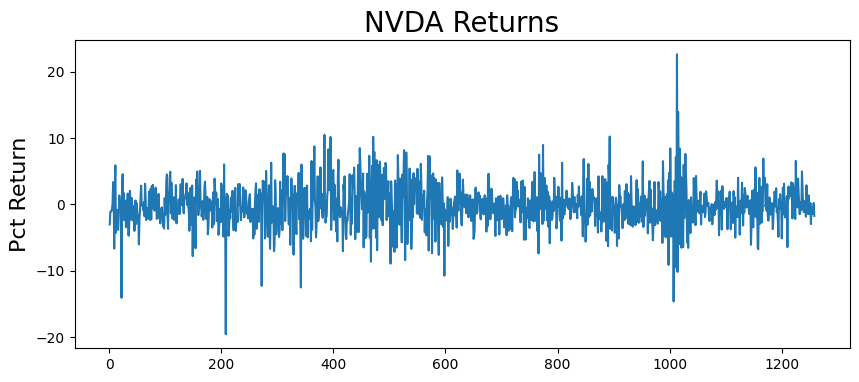

In [41]:
nvda = pd.read_csv(r"C:\Users\Xzavier\Documents\Data\Stocks\NVDA\NVDA_324_5Y.csv".replace('\\', '/'))
nvda['Close/Last'] = nvda['Close/Last'].apply(lambda x: x[1:]).astype(float)
returns = 100 * nvda['Close/Last'].pct_change().dropna()
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Pct Return', fontsize=16)
plt.title('NVDA Returns', fontsize=20)

---

# GARCH

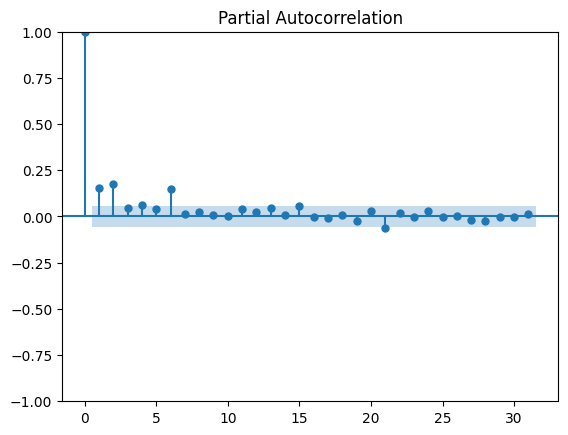

In [42]:
# Check PACF to determine model params

plot_pacf(returns**2)
plt.show()

### PACF suggests using 2 lags

In [43]:
# Fit GARCH model

model = arch_model(returns, p=2, q=2)
model_fit = model.fit()
model_fit.summary()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 5947.290150482794
Iteration:      2,   Func. Count:     17,   Neg. LLF: 4463.505227340945
Iteration:      3,   Func. Count:     25,   Neg. LLF: 541925028.0916249
Iteration:      4,   Func. Count:     33,   Neg. LLF: 3315.617641980761
Iteration:      5,   Func. Count:     41,   Neg. LLF: 3206.3768366025315
Iteration:      6,   Func. Count:     49,   Neg. LLF: 3192.5083601599736
Iteration:      7,   Func. Count:     57,   Neg. LLF: 3220.8283626528255
Iteration:      8,   Func. Count:     65,   Neg. LLF: 3173.7452345684696
Iteration:      9,   Func. Count:     73,   Neg. LLF: 3172.5225196425154
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3173.7355243368684
Iteration:     11,   Func. Count:     89,   Neg. LLF: 3170.522652821769
Iteration:     12,   Func. Count:     96,   Neg. LLF: 3170.511888039494
Iteration:     13,   Func. Count:    103,   Neg. LLF: 3170.5114092440917
Iteration:     14,   Func. Count:    110,   Neg. LLF: 317

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             Close/Last   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3170.51
Distribution:                  Normal   AIC:                           6353.02
Method:            Maximum Likelihood   BIC:                           6383.85
                                        No. Observations:                 1258
Date:                Sun, Mar 24 2024   Df Residuals:                     1257
Time:                        23:41:22   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.2735  7.710e-02     -3.548  3.889e-04 [ -0.425, -0.122]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.6824      0.206      3.313  9.217e-04    [  0.279,  1.086]
alpha[1]       0.0589  3.342e-02      1.761  7.823e-02 [-6.648e-03,  0.124]
alpha[2]       0.1218  3.641e-02      3.346  8.208e-04  [5.045e-02,  0.193]
beta[1]        0.1400  9.296e-02      1.506      0.132 [-4.223e-02,  0.322]
beta[2]        0.6178  7.817e-02      7.904  2.706e-15    [  0.465,  0.771]
===========================================================================

Covariance estimator: robust
"""

### The first beta (and alpha to a degree) coefficient is not significant, but the others are, so we'll use this model

In [44]:
# Perform Rolling predictions

rolling_predictions = []
test_size = 365

for i in range(test_size):
    train = returns[:-(test_size-i)]
    model = arch_model(train, p=2, q=2)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_predictions = pd.Series(rolling_predictions, index=returns.index[-365:])

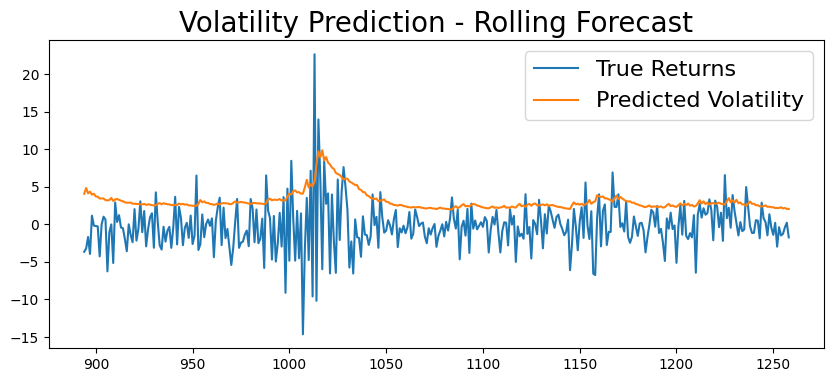

In [45]:
# Plot GARCH performance

plt.figure(figsize=(10,4))
true, = plt.plot(returns[-365:])
preds, = plt.plot(rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)
plt.show()

C:\Users\Xzavier\AppData\Local\Temp\ipykernel_34240\3543703027.py:2: FutureWarning: DataFrame.backfill/Series.backfill is deprecated. Use DataFrame.bfill/Series.bfill instead
  real_vol = returns.rolling(window=7).std().backfill()


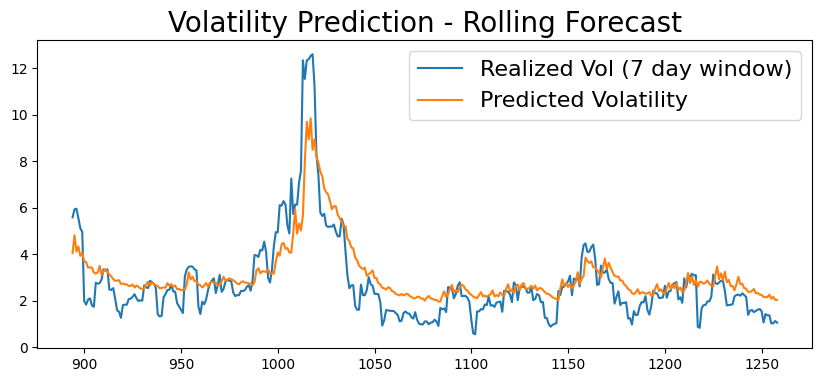

In [46]:
# Compare to realized vol
real_vol = returns.rolling(window=7).std().backfill()

plt.figure(figsize=(10,4))
true, = plt.plot(real_vol[-365:])
preds, = plt.plot(rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['Realized Vol (7 day window)', 'Predicted Volatility'], fontsize=16)
plt.show()

---

# LSTM

In [47]:
def series_to_X_y(df, window_size=5):
  # Will be used to format data
  # Window size denotes number of lags used as predictors
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [48]:
# Prepare data for LSTM

WINDOW_SIZE = 7
X1, y1 = series_to_X_y(real_vol, WINDOW_SIZE)
X1.shape, y1.shape

((1251, 7, 1), (1251,))

In [49]:
print(X1[10])
print(y1[10])

[[3.92645311]
 [4.35475354]
 [4.53206168]
 [4.24762977]
 [4.24901513]
 [3.78220146]
 [3.5219154 ]]
1.9947942416498319


In [50]:
train = int(.5*len(nvda))
validate = int(.25*len(nvda))
X_train1, y_train1 = X1[:train], y1[:train]
X_val1, y_val1 = X1[train:validate], y1[train:validate]
X_test1, y_test1 = X1[train+validate:], y1[train+validate:]

In [51]:
# Build the neural network
# This architecture comes from the linked paper

model1 = Sequential()
model1.add(InputLayer((7, 1)))
model1.add(LSTM(512,return_sequences=True))
model1.add(Dropout(.2))
model1.add(LSTM(256,return_sequences=True))
model1.add(Dropout(.2))
model1.add(LSTM(128))
model1.add(Dropout(.2))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 7, 512)         │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 7, 256)         │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,037,377 (7.77 MB)

 Trainable params: 2,037,377 (7.77 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
# Train using 100 epochs

model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100)

Epoch 1/100


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 10.4261 - root_mean_squared_error: 3.2209 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 2/100
 5/20 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 3.2855 - root_mean_squared_error: 1.8120

c:\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 2.3678 - root_mean_squared_error: 1.5287 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 1.1603 - root_mean_squared_error: 1.0763 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 1.1762 - root_mean_squared_error: 1.0836 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 1.2650 - root_mean_squared_error: 1.1236 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.0969 - root_mean_squared_error: 1.0452 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 1.2401 - root_mean_squared_error: 1.1132 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 8/100
20/2

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


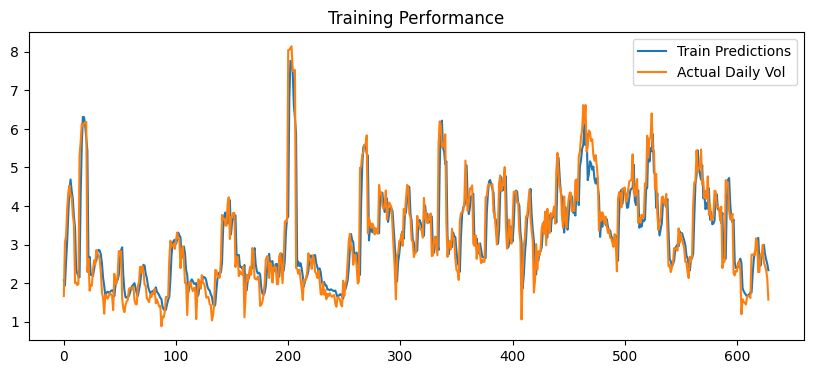

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


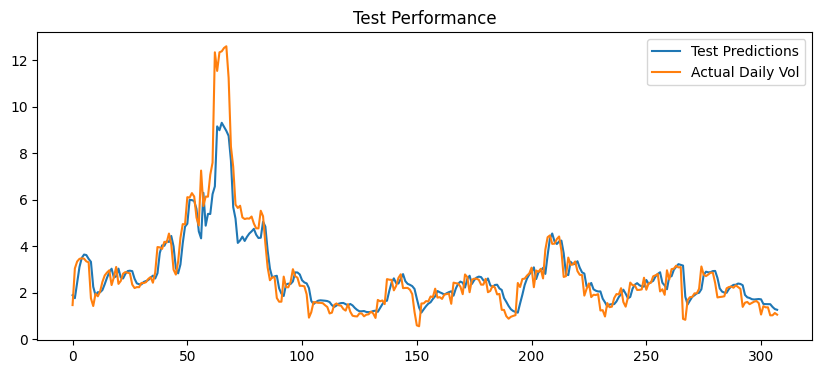

In [53]:
# LSTM performance on training and testing set

train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
plt.figure(figsize=(10,4))
plt.plot(train_results['Train Predictions'], label='Train Predictions')
plt.plot(train_results['Actuals'], label='Actual Daily Vol')
plt.legend()
plt.title('Training Performance')
plt.show()
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
plt.figure(figsize=(10,4))
plt.plot(test_results['Test Predictions'], label='Test Predictions')
plt.plot(test_results['Actuals'], label='Actual Daily Vol')
plt.legend()
plt.title('Test Performance')
plt.show()

---

# GARCH(2,2) and LSTM Comparison

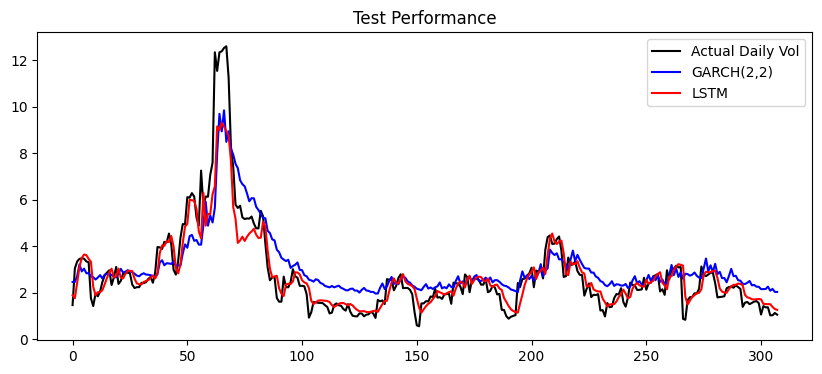

In [54]:
# Plot GARCH and LSTM performance

garch_predictions = rolling_predictions
garch_predictions = garch_predictions[-len(test_results):]
garch_predictions.index = test_results['Actuals'].index
plt.figure(figsize=(10,4))
plt.plot(test_results['Actuals'], label='Actual Daily Vol', color='k')
plt.plot(garch_predictions, label='GARCH(2,2)', color='b')
plt.plot(test_results['Test Predictions'], label='LSTM', color='r')
plt.legend()
plt.title('Test Performance')
plt.show()

In [55]:
print('GARCH MSE:', np.mean((garch_predictions-test_results['Actuals'])**2))
print('LSTM MSE:', np.mean((test_results['Test Predictions']-test_results['Actuals'])**2))

GARCH MSE: 1.0454177794989024
LSTM MSE: 0.5747035035585917


### The MSE confirms what we can visually see, that being that the LSTM does a significantly better job than the GARCH(2,2) model in predicting the realized volatility of the returns of NVDA based on a 7 day window in the test set. The caveat to this is that the neural network was trained directly on the volatility whereas GARCH was trained on the returns.

### Future exerceises should try this on different assets and using different windows to calculate realized vol.